##  Imports 

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


##  1. CSV setup 

In [ ]:
# 📂 Step 1: Load your raw sensor CSV (replace if needed)
train_path = '../test_csv/normal_2.csv'  # <-- UPDATE THIS PATH if needed
test_path = '../test_csv/motor_temp_low.csv'  # <-- UPDATE THIS PATH if needed

# 1️⃣ Load the raw file
df_train_raw = pd.read_csv(train_path)
df_test_raw = pd.read_csv(test_path)

# 2️⃣ Convert timestamps properly
df_train_raw['timestamp'] = pd.to_datetime(df_train_raw['timestamp'])
df_test_raw['timestamp'] = pd.to_datetime(df_test_raw['timestamp'])

# 3️⃣ Lock the row index for later tracing
df_train_raw['csv_index'] = df_train_raw.index
df_test_raw['csv_index'] = df_test_raw.index

# # 4️⃣ Print preview to confirm it's working
# print("📋 First 5 rows of raw CSV:")
# print(df_train_raw.head())

# # 5️⃣ Confirm the index alignment is safe
# index_check = all(df_train_raw['csv_index'] == df_train_raw.index)
# print(f"\n✅ csv_index aligned with DataFrame index? {index_check}")

## 2. Group by states

In [5]:
# 📂 Step 2: Filter temperature sensor & split by state

# 1️⃣ Filter to only the temperature sensor
df_train_temp = df_train_raw[df_train_raw['sensor'] == 'temperature'].copy()
df_test_temp = df_test_raw[df_test_raw['sensor'] == 'temperature'].copy()

# 2️⃣ Optional: Drop missing rows
df_train_temp = df_train_temp.dropna()
df_test_temp = df_test_temp.dropna()

# 3️⃣ Print unique states to confirm
print("📊 Unique states in temperature sensor data:")
print(df_train_temp['state'].value_counts())



# # 4️⃣ Show a few sample rows per state
# print("\n📋 Sample 'run' state:")
# print(df_train_temp[df_train_temp['state'] == 'run'].head(3))

# print("\n📋 Sample 'off' state:")
# print(df_train_temp[df_train_temp['state'] == 'off'].head(3))

# print("\n📋 Sample 'idle' state:")
# print(df_train_temp[df_train_temp['state'] == 'idle'].head(3))


📊 Unique states in temperature sensor data:
state
run     35520
off      4500
idle     3150
Name: count, dtype: int64


In [6]:
# 📂 Step 3: Normalize + sequence generation for 'run' state only (test)

# 1️⃣ Select 'run' state group
run_df_train = df_train_temp[df_train_temp['state'] == 'run'].copy()
run_df_test = df_test_temp[df_test_temp['state'] == 'run'].copy()

# 2️⃣ Save csv_index for traceability
index_ref_train = run_df_train['csv_index'].values
index_ref_test = run_df_test['csv_index'].values


# 3️⃣ Normalize the feature_0 column
scaler = MinMaxScaler()
run_scaled_train = scaler.fit_transform(run_df_train[['feature_0']])
run_scaled_test = scaler.transform(run_df_test[['feature_0']])

# 4️⃣ Define sequence generator
def create_sequences_debug(data, index_ref, window=20):
    sequences, start_indices, end_indices = [], [], []
    for i in range(len(data) - window):
        sequences.append(data[i:i+window])
        start_indices.append(index_ref[i])
        end_indices.append(index_ref[i + window - 1])
    return np.array(sequences), start_indices, end_indices

# 5️⃣ Create sequences
seq_len = 20
X, start_idx, end_idx = create_sequences_debug(run_scaled_train, index_ref_train, window=seq_len)
Y, start_idx_test, end_idx_test = create_sequences_debug(run_scaled_test, index_ref_test, window=seq_len)

In [10]:
# 📂 Step 4: Train and test LSTM Autoencoder on 'run' state


# 2️⃣ Build LSTM autoencoder model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    RepeatVector(X.shape[1]),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))
])
model.compile(optimizer=Adam(1e-3), loss='mse')

# 3️⃣ Train the model
model.fit(X, X, epochs=10, batch_size=128, validation_split=0.2, verbose=1)


Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0771 - val_loss: 0.0073
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 9/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 10/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0059 - val_loss: 0.0061


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📊 Reconstruction threshold (95th percentile): 0.085160

📋 Sample predictions and their end_csv_index:


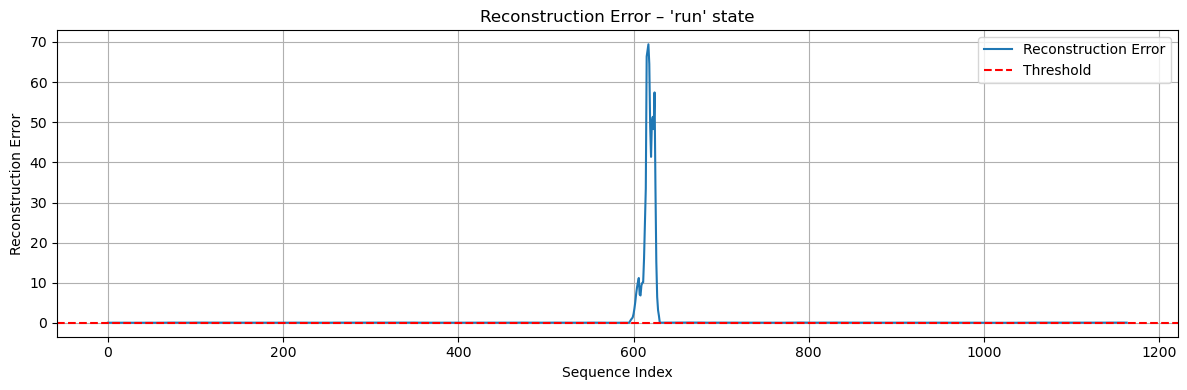

In [12]:

# 4️⃣ Predict and calculate reconstruction error
pred = model.predict(Y)
errors = np.mean(np.abs(pred - Y), axis=(1, 2))

# 5️⃣ Threshold: 95th percentile
threshold = np.percentile(errors, 95)
print(f"\n📊 Reconstruction threshold (95th percentile): {threshold:.6f}")

# 6️⃣ Print sample errors + matched timestamps
print("\n📋 Sample predictions and their end_csv_index:")
# for i in range(5):
#     print(f"🔍 Row {i} | error={errors[i]:.6f} | end_csv_index={end_test[i]} | timestamp={df_train_raw.loc[end_test[i], 'timestamp']}")

# 7️⃣ Plot
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(errors)), errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error – 'run' state")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 📂 Step 5: Final result table for 'run' state

is_anomaly = (errors > threshold).astype(int)

result_df = pd.DataFrame({
    'start_csv_index': start_test,
    'end_csv_index': end_test,
    'timestamp': df_train_raw.loc[end_test, 'timestamp'].values,
    'state': 'run',
    'reconstruction_error': errors,
    'is_anomaly': is_anomaly
})

# 🧪 Print sample
print("📋 Final predictions sample:")
display(result_df.head(10))

# ✅ Save to variable for later
run_results_df = result_df.copy()


📋 Final predictions sample:


,start_csv_index,end_csv_index,timestamp,state,reconstruction_error,is_anomaly
0,1186,1205,2025-04-07 20:05:00,run,0.019322,0
1,1187,1206,2025-04-07 20:06:00,run,0.018499,0
2,1188,1207,2025-04-07 20:07:00,run,0.017024,0
3,1189,1208,2025-04-07 20:08:00,run,0.014977,0
4,1190,1209,2025-04-07 20:09:00,run,0.018427,0
5,1191,1210,2025-04-07 20:10:00,run,0.020428,0
6,1192,1211,2025-04-07 20:11:00,run,0.020165,0
7,1193,1212,2025-04-07 20:12:00,run,0.016868,0
8,1194,1213,2025-04-07 20:13:00,run,0.017613,0
9,1195,1214,2025-04-07 20:14:00,run,0.018944,0


In [ ]:
# 📂 Stage 3: Filter out anomalies during state transitions

# 1️⃣ Set how many rows before/after a transition to flag
transition_window = 3

# 2️⃣ Re-merge run_results_df with all other states (if needed later)
transition_df = run_results_df.copy().reset_index(drop=True)
transition_df['is_transition'] = 0

# 3️⃣ Flag transitions (basic logic here assumes one state only, later we’ll do multi-state logic)
for i in range(1, len(transition_df)):
    if transition_df.loc[i, 'start_csv_index'] - transition_df.loc[i-1, 'end_csv_index'] > 1:
        for j in range(i - transition_window, i + transition_window + 1):
            if 0 <= j < len(transition_df):
                transition_df.loc[j, 'is_transition'] = 1

# 4️⃣ Final filtered anomalies
final_anomalies_df = transition_df[
    (transition_df['is_anomaly'] == 1) & (transition_df['is_transition'] == 0)
]

# 5️⃣ Show sample
print(f"✅ Final anomaly count (after transition filter): {len(final_anomalies_df)}")
display(final_anomalies_df.head(10))


✅ Final anomaly count (after transition filter): 12


,start_csv_index,end_csv_index,timestamp,state,reconstruction_error,is_anomaly,is_transition
132,1318,1337,2025-04-07 22:17:00,run,0.025234,1,0
135,1321,1340,2025-04-07 22:20:00,run,0.025446,1,0
136,1322,1341,2025-04-07 22:21:00,run,0.025083,1,0
137,1323,1342,2025-04-07 22:22:00,run,0.024974,1,0
140,1326,1345,2025-04-07 22:25:00,run,0.025014,1,0
210,1396,1415,2025-04-07 23:35:00,run,0.025721,1,0
219,1405,1424,2025-04-07 23:44:00,run,0.025286,1,0
220,1406,1425,2025-04-07 23:45:00,run,0.026570,1,0
221,1407,1426,2025-04-07 23:46:00,run,0.025639,1,0
224,1410,1429,2025-04-07 23:49:00,run,0.025808,1,0
